### Global setup

In [1]:
%matplotlib inline

In [2]:
%pwd

'/home/gabe/work/fast-ai/lesson1/nbs'

### Library imports

In [3]:
import os
import sys
import json
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
from importlib import reload

### Library setup

In [4]:
np.set_printoptions(precision=4, linewidth=100)
sys.path.append(r'../src')

### Local imports

In [5]:
import utils
reload(utils)

import plothelper
reload(plothelper)

import train
reload(train)

from trainhelper import *
from plothelper import *
from utils import *
from train import *

from PIL import Image

Using TensorFlow backend.


### Train model and save results

In [7]:
train_and_test(no_of_epochs=6)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Running epoch: 0
Epoch 1/1


../src/vgg16wrapper.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  self.model = Model(inputs=img_input, output=x)


360/360 [==============================] - 84s - loss: 0.6964 - acc: 0.9444 - val_loss: 0.6453 - val_acc: 0.9530
Running epoch: 1
Epoch 1/1
360/360 [==============================] - 84s - loss: 0.6324 - acc: 0.9546 - val_loss: 0.5125 - val_acc: 0.9645
Running epoch: 2
Epoch 1/1
360/360 [==============================] - 85s - loss: 0.6479 - acc: 0.9562 - val_loss: 0.5120 - val_acc: 0.9635
Running epoch: 3
Epoch 1/1
360/360 [==============================] - 85s - loss: 0.6325 - acc: 0.9569 - val_loss: 0.4163 - val_acc: 0.9720
Running epoch: 4
Epoch 1/1
360/360 [==============================] - 86s - loss: 0.6533 - acc: 0.9566 - val_loss: 0.5022 - val_acc: 0.9647
Running epoch: 5
Epoch 1/1
360/360 [==============================] - 86s - loss: 0.6104 - acc: 0.9596 - val_loss: 0.5195 - val_acc: 0.9670
Completed 6 fit operations
Found 12500 images belonging to 1 classes.


(<keras.preprocessing.image.DirectoryIterator at 0x7f2234ba9240>,
 array([[ 1.,  0.],
        [ 1.,  0.],
        [ 0.,  1.],
        ..., 
        [ 1.,  0.],
        [ 1.,  0.],
        [ 0.,  1.]], dtype=float32))

### Load results and prepare a submission file

['../data/test/unknown/532.jpg', '../data/test/unknown/10860.jpg', '../data/test/unknown/5928.jpg', '../data/test/unknown/11799.jpg', '../data/test/unknown/9775.jpg']
[[ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]


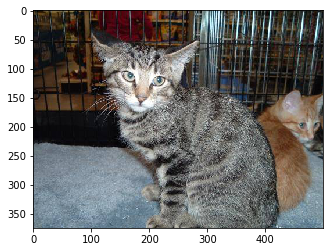

In [11]:
DATA_DIR = '../data'
TEST_DIR = DATA_DIR + '/test'

filenames, test_preds = load_pred_data()
paths = list(map(lambda x: TEST_DIR + '/' + x, filenames))

print(paths[:5])
print(test_preds[:5])

show_image(paths[1])

In [12]:
is_dog = test_preds[:,1]

print(is_dog[:5])
print(is_dog[(is_dog < 0.6) & (is_dog > 0.4)])
print(is_dog[(is_dog == 1) & (is_dog == 0)])

[ 0.  0.  1.  1.  1.]
[ 0.5027]
[]


In [17]:
is_dog = is_dog.clip(min=0.03, max=0.97)
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

print(ids[:5], is_dog[:5])

subm = np.stack([ids, is_dog], axis=1)
print(subm[:5])

[  532 10860  5928 11799  9775] [ 0.05  0.05  0.95  0.95  0.95]
[[  5.3200e+02   5.0000e-02]
 [  1.0860e+04   5.0000e-02]
 [  5.9280e+03   9.5000e-01]
 [  1.1799e+04   9.5000e-01]
 [  9.7750e+03   9.5000e-01]]


In [18]:
np.savetxt(DATA_DIR + '/results/submission.csv', subm, fmt='%d,%.5f', header='id,label', comments='')